In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.cluster import DBSCAN
from tqdm import tqdm

In [2]:
path = "DAS_data/"
images = []
target_shape = (585, 153)
for file in tqdm(os.listdir(path)):
    img = np.load(os.path.join(path, file))
    h, w = img.shape[:2]
    target_h, target_w = target_shape

    crop_h = min(h, target_h)
    crop_w = min(w, target_w)
    img_cropped = img[:crop_h, :crop_w]
    images.append(img_cropped)

stacked = np.stack(images, axis=0)
print(stacked.shape)
mu = stacked.mean(axis = 0)
print(mu.shape)
var = stacked.var(axis = 0)
print(var.shape)


100%|██████████████████████████████████████| 2334/2334 [00:02<00:00, 816.85it/s]


(2334, 585, 153)
(585, 153)
(585, 153)


In [3]:
def normalize(a):
    a = (a - np.min(a))/(np.max(a) - np.min(a))
    return a

def detected_lines(path):
    orig_img = np.load(path).T
    img = normalize(orig_img)
    img[img<0.5] = 0
    img = (255*np.stack([img]*3, axis=-1)).astype(np.uint8)
    # Load and process image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    # Get (x, y) coordinates of all edge pixels
    points = np.column_stack(np.where(edges > 0))  # (y, x)
    points = points[:, ::-1]  # convert to (x, y)

    # Use DBSCAN to cluster edge points
    db = DBSCAN(eps=10, min_samples=20).fit(points)
    labels = db.labels_

    # For visualization
    result = img.copy()
    unique_labels = set(labels)
    lines = []
    line_intensities = []
    for label in unique_labels:
        if label == -1:
            continue  # noise

        cluster_points = points[labels == label]
        x = cluster_points[:, 0]
        y = cluster_points[:, 1]
        
        if len(x) < 10:
            continue

        # Fit least squares line: y = mx + b
        A = np.vstack([x, np.ones(len(x))]).T
        m, b = np.linalg.lstsq(A, y, rcond=None)[0]

        # Filter only diagonal-ish lines
        if abs(m) < 0.2:
            continue

        # Start/end points for drawing
        x_start, x_end = np.min(x), np.max(x)
        y_start = int(m * x_start + b)
        y_end = int(m * x_end + b)

        cv2.line(result, (x_start, y_start), (x_end, y_end), (0, 0, 255), 2)
        lines.append([m, x_start, y_start, x_end, y_end])
        intensity = normalize(orig_img.T)[cluster_points]
        avg = intensity.mean()
        var = intensity.var()
        line_intensities.append([avg, var])
    return lines, line_intensities

In [4]:
lines = []
stren = []
for file in tqdm(os.listdir(path)):
    file = os.path.join(path, file)
    info, intensities = detected_lines(file)
    lines.extend(info)
    stren.extend(intensities)

100%|███████████████████████████████████████| 2334/2334 [04:26<00:00,  8.75it/s]


In [5]:
stren = np.asarray(stren)

In [6]:
stren.shape

(3015, 2)

In [7]:
flat_intensities = []
for i in stren:
    flat_intensities.extend(i)

In [8]:
avgs = stren[:, 0]
v = stren[:, 1]
intensity_avg = np.mean(avgs)
intensity_var = np.mean(v)
print(intensity_avg, intensity_var)

0.2737120983923772 0.007496117992058121


In [9]:
def get_thick_line_pixels(point1: tuple, point2: tuple, thickness: int = 1):
    """
    Returns a list of (x, y) pixel coordinates that form a line of given thickness
    between point1 and point2.

    thickness: radius around the ideal line in pixels.
    """
    line_pixels = get_line_pixels(point1, point2)
    thick_pixels = set()

    for (x, y) in line_pixels:
        # Create a square of size (2*thickness + 1) around each pixel
        for dx in range(-thickness, thickness + 1):
            for dy in range(-thickness, thickness + 1):
                thick_pixels.add((x + dx, y + dy))

    return list(thick_pixels)

def get_line_pixels(start, end):
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    x1 = int(x1)
    x2 = int(x2)
    y1 = int(y1)
    y2 = int(y2)
    dx = x2 - x1
    dy = y2 - y1
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)

    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2

    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True

    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1

    # Calculate error
    error = dx // 2
    ystep = 1 if y1 < y2 else -1

    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx

    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points

In [10]:
lines = np.asarray(lines)
slopes = lines[:, 0]
print(slopes)
avg_slope = np.abs(slopes).mean()
print(avg_slope)
var_slope = np.abs(slopes).var()
print(var_slope)
slope_pos_prob = np.mean(slopes>0)
print(slope_pos_prob)

[-0.45856354 -0.56892363 -0.59948911 ... -0.64598925  0.31283898
  0.55860318]
0.5253884980662408
0.12718836844322423
0.24344941956882254


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_line_on_image(image: np.ndarray, point1: tuple, point2: tuple):
    plt.imshow(image)
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'r-', linewidth=2)
    plt.axis('off')  # Optional: hides axis
    plt.show()

In [58]:
def generate_line(syn_img, start_x, start_y, line_x_end, line_y_end, thickness = 3):
    line_px = get_thick_line_pixels((start_x, start_y), (line_x_end, line_y_end), thickness = thickness)
    line_px = np.asarray(line_px)
    drop_prob1 = 0
    drop_prob2 = 0
    length = 0
    for (x, y) in line_px:
        if x < 585 and y < 150:
            if np.random.uniform() > drop_prob2:
                syn_img[y, x] = np.random.normal(intensity_avg + 0.9*np.mean(syn_img), intensity_var)
                length += 1

In [61]:
def generate_car():
    syn_img = np.random.randn(*target_shape)
    syn_img = syn_img * np.sqrt(var) + mu
    syn_img = normalize(syn_img.T)
    plt.imshow(syn_img)
    slope = -np.random.randn(1)[0] * var_slope - avg_slope
    print(slope)
    start_x = np.random.randint(0, target_shape[0]-100)
    start_y = np.random.randint(0, target_shape[1])
    print(start_x, start_y) 
    img_x_end = target_shape[0]
    img_y_end = 0
    line_y_end = start_y + slope*(img_x_end - start_x)
    line_x_end = start_x + (img_y_end - start_y)/slope
    if line_y_end < 0:
        line_y_end = 0
    elif line_x_end > img_x_end:
        line_x_end = img_x_end
    generate_line(syn_img, start_x, start_y, img_x_end, img_y_end)
    plt.imshow(np.flipud(normalize(syn_img)))

-0.31905742658341174
411 31


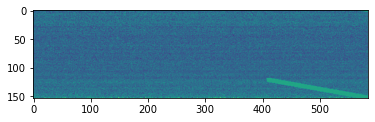

In [74]:
generate_car()